> This notebook is adapted from the tutorial https://mbernste.github.io/posts/diffusion_part1/

# A simple denoising diffusion probabilistic model applied to MNIST

This notebook demonstrates how to implement a denoising diffusion probabilistic model (DDPM) from scratch, specifically applied to the MNIST dataset. It is part of the hands-on section of the Diffusion Models Minicourse at SBBD 2025. 

DDPMs are a class of generative models that learn to reverse a gradual noising process, allowing us to generate new data samples from pure noise.

## Import dependencies
We start by importing all necessary libraries for data handling, model building, training, and visualization. This includes PyTorch for deep learning, torchvision for datasets and transforms, and matplotlib/seaborn for plotting.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm
from models.ddpm import UNet

Variable that controls if the model will be retrained or not:

In [2]:
load_model = True

## Implementation of the U-Net

The U-Net architecture is a popular neural network design for image-to-image tasks, especially in segmentation and generative modeling. Here, it is adapted to predict noise in the diffusion process. The network consists of downsampling blocks (encoder), a bottleneck, and upsampling blocks (decoder), with skip connections to preserve spatial information.

Architecture:
The diagram below illustrates the U-Net structure used in this notebook. Each block is responsible for extracting and reconstructing features at different resolutions.

<img width="700" src="https://raw.githubusercontent.com/mbernste/mbernste.github.io/master/images/diffusion_unet_for_MNIST.png" />

The code of the UNet implementation is available on file [model.py](./model.py).

In [3]:
# Test run the model to make sure tensors flow through it
print(UNet()(torch.randn(1, 1, 28, 28), torch.randn(1, 60)).shape)

torch.Size([1, 1, 28, 28])


## Timestep embeddings

To help the model understand the progression of the diffusion process, we use timestep embeddings. These embeddings encode the current step in the diffusion chain, allowing the neural network to condition its predictions on the amount of noise present at each stage. The embedding is constructed using sinusoidal functions, similar to positional encodings in transformer models, which enables the network to capture both absolute and relative positions in the sequence. For more details on sinusoidal positional encodings, see [this explanation](https://medium.com/@hirok4/understanding-transformer-sinusoidal-position-embedding-7cbaaf3b9f6a).

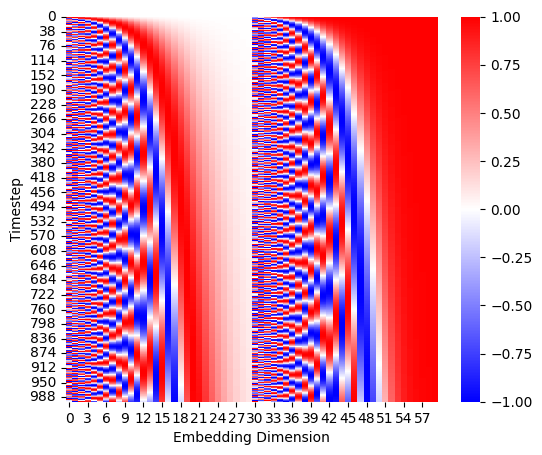

In [4]:
def get_timestep_embedding(timesteps, embedding_dim: int):
  """
  Translated from Tensorflow to PyTorch by the original Diffusion implementation
  by Ho et al.
  """
  assert len(timesteps.shape) == 1  # and timesteps.dtype == torch.int32

  half_dim = embedding_dim // 2
  emb = np.log(10000) / (half_dim - 1)
  emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
  emb = timesteps[:, None].to(torch.float32) * emb[None, :]
  emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
  if embedding_dim % 2 == 1:  # zero pad
    emb = torch.nn.functional.pad(emb, (0, 1))
  assert emb.shape == (timesteps.shape[0], embedding_dim)
  return emb

# Plot some test embeddings
test_time_embeddings = get_timestep_embedding(
    torch.arange(0,1000), embedding_dim=60
)
fig, ax = plt.subplots(1,1,figsize=(6,5))
sns.heatmap(test_time_embeddings, cmap='bwr', ax=ax)
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Timestep')
plt.show()

## Variance schedule

The variance schedule determines how much noise is added at each step of the diffusion process. A linear schedule is used here, gradually increasing the noise level from a minimum to a maximum value over all timesteps. This schedule is crucial for stable training and effective sample generation.

In [5]:
def linear_variance_schedule(min: float, max: float, T: int):
  """
  min: minimum value for beta
  max: maximum value for beta
  T: number of timesteps
  """
  betas = torch.arange(0, T) / T
  betas *= max - min
  betas += min
  return betas

# Test variance schedule
print(linear_variance_schedule(0.1, 0.9, 100))

tensor([0.1000, 0.1080, 0.1160, 0.1240, 0.1320, 0.1400, 0.1480, 0.1560, 0.1640,
        0.1720, 0.1800, 0.1880, 0.1960, 0.2040, 0.2120, 0.2200, 0.2280, 0.2360,
        0.2440, 0.2520, 0.2600, 0.2680, 0.2760, 0.2840, 0.2920, 0.3000, 0.3080,
        0.3160, 0.3240, 0.3320, 0.3400, 0.3480, 0.3560, 0.3640, 0.3720, 0.3800,
        0.3880, 0.3960, 0.4040, 0.4120, 0.4200, 0.4280, 0.4360, 0.4440, 0.4520,
        0.4600, 0.4680, 0.4760, 0.4840, 0.4920, 0.5000, 0.5080, 0.5160, 0.5240,
        0.5320, 0.5400, 0.5480, 0.5560, 0.5640, 0.5720, 0.5800, 0.5880, 0.5960,
        0.6040, 0.6120, 0.6200, 0.6280, 0.6360, 0.6440, 0.6520, 0.6600, 0.6680,
        0.6760, 0.6840, 0.6920, 0.7000, 0.7080, 0.7160, 0.7240, 0.7320, 0.7400,
        0.7480, 0.7560, 0.7640, 0.7720, 0.7800, 0.7880, 0.7960, 0.8040, 0.8120,
        0.8200, 0.8280, 0.8360, 0.8440, 0.8520, 0.8600, 0.8680, 0.8760, 0.8840,
        0.8920])


## Training and model parameters

Here we define the key hyperparameters for training the DDPM, such as the number of epochs, timesteps, learning rate, batch size, and the variance range. These parameters control the training duration, model capacity, and the behavior of the diffusion process.

In [6]:
# Parameters
EPOCHS = 300
T = 1000
LEARNING_RATE = 1e-4
BATCH_SIZE = 128
MIN_VARIANCE = 1e-4
MAX_VARIANCE = 0.02
DEVICE = 'cuda'

## Load the data

We load the MNIST dataset, which consists of handwritten digit images. Both the training and test sets are combined to maximize the available data. Images are normalized to have values between -1 and 1, which helps the model learn more effectively. A data loader is created to efficiently batch and shuffle the data during training. An example image is displayed to verify the data loading process.

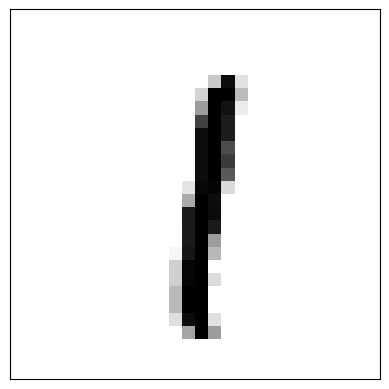

In [7]:
train_dataset = MNIST(
  "./data",
  train=True,
  download=True,
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
  ])
)
test_dataset = MNIST(
  "./data",
  train=True,
  download=True,
  transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
  ])
)

# Concatenate training and test data
dataset = ConcatDataset([train_dataset, test_dataset])

# Create data loader
dataloader = DataLoader(
  dataset,
  batch_size=128,
  shuffle=True,
  num_workers=1
)

# Show example image
X_example = next(iter(dataloader))[0][0]
plt.imshow((X_example.detach().cpu().numpy().squeeze()+1.)/2., cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.show()

## Train the model

This section covers the training loop for the DDPM. The model learns to predict the noise added to images at random timesteps, using the U-Net architecture. The loss function is mean squared error (MSE) between the true and predicted noise. The optimizer updates the model weights to minimize this loss. Periodic checkpoints are saved for later use.

In [15]:
# Compute variance schedule
betas = linear_variance_schedule(MIN_VARIANCE, MAX_VARIANCE, T).to(DEVICE)

# Compute constants based on variance schedule
alphas = 1 - betas
onemalphas = 1 - alphas
alpha_bar = torch.exp(torch.cumsum(torch.log(alphas), dim=0))
sqrt_alphabar = torch.sqrt(alpha_bar)
onemalphabar = 1-alpha_bar
sqrt_1malphabar = torch.sqrt(1-alpha_bar)

# Instantiate the noise model, loss function, and optimizer
noise_model = UNet().to(DEVICE)
optimizer = optim.Adam(noise_model.parameters(), lr=LEARNING_RATE)
mse_loss = nn.MSELoss().to(DEVICE)

# Generate timestep embeddings. Note, the embedding dimension is hardcoded
# and based on the number of channels at the bottom layer of the U-Net
# noise model
time_embeddings = get_timestep_embedding(
  torch.arange(0,T),
  embedding_dim=60
).to(DEVICE)

if not load_model:
  # The training loop
  epoch_losses = []
  for epoch in range(EPOCHS):
    loss_sum = 0
    n_batchs = 0
    for b_i, (X_batch, _) in enumerate(dataloader):
      n_batchs += 1

      # Move batch to device
      X_batch = X_batch.to(DEVICE)

      # Sample noise for each pixel and image in this batch
      # B x M x N matrix where B is minibatch size, M is number
      # of rows in each image and N is number of columns in the
      # each image
      eps = torch.randn_like(X_batch).to(DEVICE)

      # Get a random timepoint for each item in this batch
      # B x 1 matrix
      ts = torch.randint(
          1, T+1, size=(X_batch.shape[0],)
      ).to(DEVICE)

      # Grab the time-embeddings for each of these sampled timesteps
      # B x D matrix where B is minibatch size and D is time embedding
      # dimension
      t_embs = time_embeddings[ts-1].to(DEVICE)

      # Compute X_batch after adding noise via the diffusion process for each of
      # the items in the batch (at the sampled per-item timepoints, `ts`)
      # B x M x N matrix
      sqrt_alphabar_ts = sqrt_alphabar[ts-1]
      sqrt_1malphabar_ts = sqrt_1malphabar[ts-1]
      X_t = sqrt_alphabar_ts[:, None, None, None] * X_batch \
        +  sqrt_1malphabar_ts[:, None, None, None] * eps

      # Predict the noise from our sample using the UNet
      # B x M x N matrix
      pred_eps = noise_model(X_t, t_embs)

      # Compute the loss between the real noise and predicted noise
      loss = mse_loss(eps, pred_eps)
      loss_sum += float(loss)

      # Update the weights in the U-Net via a step of gradient descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Save model periodically as a checkpoint
      if epoch in [49, 99, 149, 199, 249]:
        torch.save(
          noise_model.state_dict(), f'./model_state_{epoch+1}epochs.pickle'
        )

    print(f"Epoch: {epoch}. Mean loss: {loss_sum/n_batchs}")
    epoch_losses.append(loss_sum/n_batchs)

## Plot the learning curve

After training, we plot the learning curve to visualize how the loss decreases over epochs. This helps assess the model's convergence and training stability.

In [16]:
if not load_model:
    fig, ax = plt.subplots(1,1, figsize=(4,5))
    ax.plot(np.arange(0, 300), epoch_losses, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    plt.show()

## Save the model

Once training is complete, the model's weights are saved to disk. This allows us to reload the trained model later for inference or further training.

In [ ]:
if not load_model:
    torch.save(noise_model.state_dict(), './weights/ddpm_300epochs.pickle')

## Load a model (if it has already been trained)

If a trained model checkpoint exists, we can load it to skip retraining. This is useful for generating samples or continuing training from a previous state.

In [ ]:
if load_model:
  noise_model = UNet()
  noise_model.load_state_dict(torch.load('./weights/ddpm_300epochs.pickle'))
  noise_model = noise_model.to(DEVICE)

## Generate an image

In this section, we use the trained DDPM to generate new MNIST-like images from pure noise. The sampling function iteratively denoises a random image, reversing the diffusion process. Intermediate and final results are displayed to visualize the generative process.

100%|██████████| 1000/1000 [00:06<00:00, 150.18it/s]


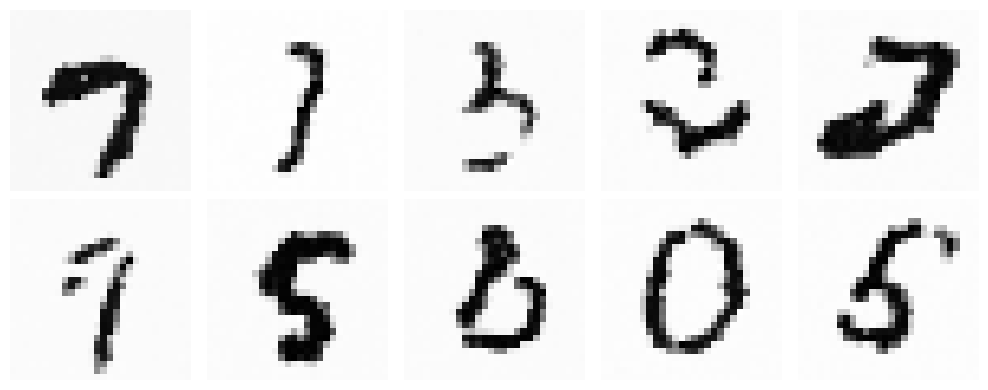

In [19]:
def sample_from_model(T=999, n_images=10, show_img_mod=None, cmap='viridis', return_img=True):
  # Initialize the image to white noise
  X_t = torch.randn(n_images, 1, 28, 28).to(DEVICE)

  for t in tqdm(range(T, -1, -1)):
    if t > 1:
      Z = torch.randn(n_images, 1, 28, 28).to(DEVICE)
    else:
      Z = torch.zeros(n_images, 1, 28, 28).to(DEVICE)

    t_emb = time_embeddings[t][None,:]
    pred_eps = noise_model(X_t, t_emb)

    one_over_sqrt_alpha_t = 1 / torch.sqrt(alphas[t])
    pred_noise_scale = betas[t] / sqrt_1malphabar[t]
    sqrt_beta_t = torch.sqrt(betas[t])

    X_t = (one_over_sqrt_alpha_t * (X_t - (pred_eps * pred_noise_scale))) \
      + (sqrt_beta_t * Z)

  if return_img:
    img = (X_t.detach().cpu().numpy().squeeze() + 1.) / 2.
    return img
  else:
    return None

def plot_sample_grid(n_images=10, nrows=2, ncols=5, cmap='Greys'):
  imgs = sample_from_model(n_images=n_images, show_img_mod=None, cmap=cmap, return_img=True)
  fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))
  for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i], cmap=cmap)
    ax.axis('off')
  plt.tight_layout()
  plt.show()


plot_sample_grid(n_images=10, nrows=2, ncols=5, cmap='Greys')